In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard, make_moons, make_circles,make_swiss_roll,make_s_curve,make_blobs
import torch

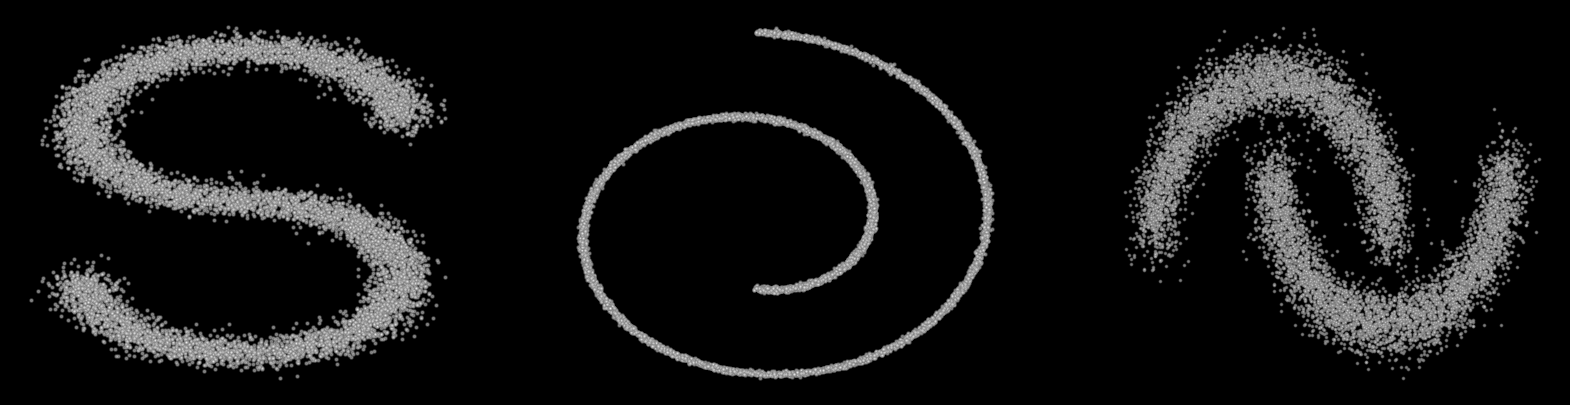

In [5]:
from helper_plot import hdr_plot_style
from utils import *
hdr_plot_style()
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T
#dataset = torch.Tensor(data.T).float()

fig,axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[0].axis('off')

data = swiss_roll.T
axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[1].axis('off')
#dataset = torch.Tensor(data.T).float()

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
axes[2].axis('off')
dataset = torch.Tensor(data.T).float()

In [6]:
num_steps = 100
betas = make_beta_schedule('sigmoid',num_steps,1e-5,0.5e-2)

alphas = 1 - betas
alphas_prod = np.cumprod(alphas)
alphas_prod_p = torch.cat([torch.tensor([1.0]),torch.tensor(alphas_prod[:-1])])
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1.0 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1.0 - alphas_prod)

/tmp/ipykernel_3082839/154010046.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alphas_prod_p = torch.cat([torch.tensor([1.0]),torch.tensor(alphas_prod[:-1])])


In [ ]:
def q_x(x_0,t,noise = None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt,t,x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt,t,x_0)
    return alphas_t*x_0 + alphas_1_m_t*noise